In [1]:
import numpy

import pandas

# local helper lib
import wrf_utils

# suds-jurko
from suds.client import Client

from datetime import datetime 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import pyepsg
import folium
import geopandas

import dask
import xarray
from dask.distributed import Client as daskClient

import cartopy.crs as ccrs

%matplotlib notebook

In [2]:
# start a dask client to monitor jobs
# see https://examples.dask.org/xarray.html
daskclient = daskClient(n_workers=2, threads_per_worker=2, memory_limit='1GB')
daskclient

Client Scheduler: tcp://127.0.0.1:64345 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 4 Memory: 2.00 GB


In [3]:
# collect NWIS gages
client = Client('http://hydroportal.cuahsi.org/nwisdv/cuahsi_1_1.asmx?WSDL')
west = -92.217
south = 41.422
east =  -91.421
north = 41.986
response = client.service.GetSitesByBoxObject(west, south, east, north, False, '')


In [4]:
#usgs_gages = wrfsim.list_usgs_gages()
m = folium.Map(tiles='Stamen terrain', zoom_start=11)

# add watershed
watershed = geopandas.GeoDataFrame.from_file('../spatial/watershed.shp')
watershed_json = watershed.to_crs(epsg='4326').to_json()
w = folium.features.GeoJson(data=watershed_json)
m.add_child(w)

# add nhd
nhd = geopandas.GeoDataFrame.from_file('../spatial/nhd_subset.shp')
nhd_json = nhd.to_crs(epsg='4326').to_json()
w = folium.features.GeoJson(data=nhd_json)
m.add_child(w)

# add point on map for each NWISDV site
for site in response.site:
    siteid = site.siteInfo.siteCode[0].value
    sitename = site.siteInfo.siteName
    lat = site.siteInfo.geoLocation.geogLocation.latitude
    lon = site.siteInfo.geoLocation.geogLocation.longitude
    html = f"""
           <html>
            <b>ID: </b>{siteid}<br>
            <b>Name: </b>{sitename}<br>
            <b>Service: </b>NWISDV<br>
           </html>
           """
    popup = folium.Popup(folium.Html(html, script=True), max_width=2650)
    folium.Marker(location=[float(lat), float(lon)], 
                  icon=folium.Icon(color='blue'),
                  popup=popup,
                 ).add_to(m)
    
# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())
m

### Load GHCN from CSV

In [5]:
# load gage precip data collected via data.cuahsi.org

fname ='ghcn-iowa_city_muni_ap-precipitation.csv'
df_ghcn = pandas.read_csv(fname, skiprows=2)

# parse dates
df_ghcn['date'] = pandas.to_datetime(df_ghcn['LocalTimestamp'], format='%Y-%m-%d')

### Collect NWIS DV Streamflow

In [6]:
# collect NWIS DV Streamflow

usgs_gageid = '05454300'

client = Client('http://hydroportal.cuahsi.org/nwisdv/cuahsi_1_1.asmx?WSDL')
start_date = '2018-05-01'
end_date = '2018-08-30'
variable_code = '00060'

# collect data 
site_code = f'NWIS:{usgs_gageid}'
variable_code = '00060/DataType=MEAN'
response = client.service.GetValuesObject(site_code,
                                          variable_code,
                                          start_date,
                                          end_date,
                                          '')
# parse the WOF response into a timeseries
data = response.timeSeries[0]
values = data.values[0]
variable = data.variable
nwis_series = []
nwis_metadata = dict(varname=variable.variableName,
                     varunit=variable.units.unitsAbbreviation)
for item in values[0]:
    v = float(item.value) / 3.28**3
    t = item._dateTime
    nwis_series.append([v, t])    

### Plot measured precipitation and streamflow

<IPython.core.display.Javascript object>


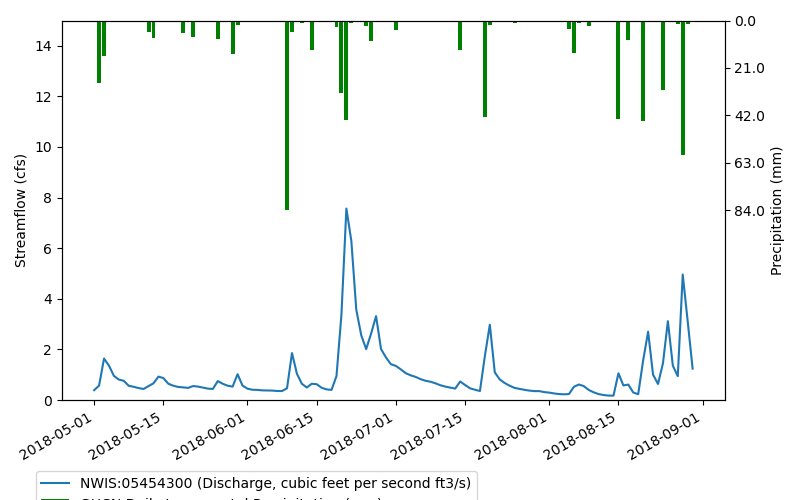

In [7]:
# create plot
fig = plt.figure(figsize=(8, 5))
ax = plt.gca()

y, x = list(zip(*nwis_series))

# plot nwis
nwis = ax.plot_date(x, y, '-', label=f'{site_code} ({nwis_metadata["varname"]} {nwis_metadata["varunit"]})')
ax.set_ylabel('Streamflow (cfs)')
ax.set_ylim(0, 15)

# plot GHCN data (stored in CSV, collected from data.cuahsi.org)
ax2 = ax.twinx()
precip = df_ghcn[(df_ghcn.date >= datetime.strptime(start_date, '%Y-%m-%d')) & \
                 (df_ghcn.date <= datetime.strptime(end_date, '%Y-%m-%d')) ]
ghcn = ax2.bar(precip.date, -precip.Value, color='green', label='GHCN Daily Incremental Precipitation (mm)')

# format the precipitation axis
max_pre = max(precip.Value)
ax2.set_ylim(max_pre*-2, 0)
y2_ticks = numpy.linspace(0, max_pre, 5)
ax2.set_yticks(-1 * y2_ticks)
y2_ticklabels = [str(round(i,0)) for i in y2_ticks]
ax2.set_yticks(-1 * y2_ticks)
ax2.set_yticklabels(y2_ticklabels)
ax2.set_ylabel('Precipitation (mm)')

# add these all lines to list
lns = nwis+[ghcn]
labs = [l.get_label() for l in lns]

# put the legend outside the plot
plt.legend(lns, labs, bbox_to_anchor=(-.05, -.17), loc='upper left', ncol=1)

fig.autofmt_xdate()
plt.tight_layout()

# Analyze the NLDAS Forcing Data

### Load NLDAS data that has already been regridded for WRF-Hydro

In [8]:
# load the NLDAS data for the model
nldas_forcing = '../FORCING/201808*LDASIN_DOMAIN1'
ds = xarray.open_mfdataset(nldas_forcing,
                           concat_dim='Times',
                           parallel=True,
                           combine='nested')
ds = ds.squeeze(dim='Time')

In [9]:
dt = ds.Times
ds = ds.drop('Times')

# create coordinates for spatial plotting
ds = ds.assign_coords(coords={'yc': ds.lat[0],
                              'xc': ds.lon[0],
                              'Times': dt})

## Check that the Re-gridded NLDAS data overlaps with our watershed

<IPython.core.display.Javascript object>


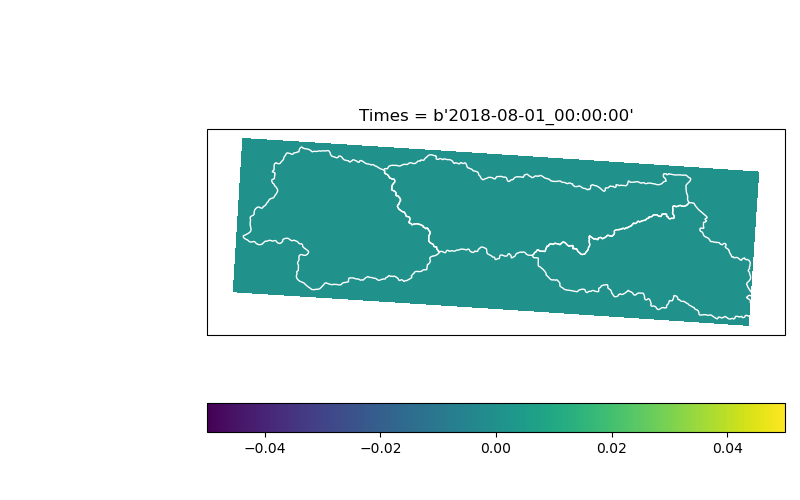

In [10]:
# spatially plot a single timestep of the NLDAS RAINRATE variable along with the 
# watershed boundary. This is just a sanity check that the NLDAS FORCING data 
# overlaps our watershed boundary

f, ax = plt.subplots(1, figsize=(8, 5))

# create an AlbersEqualArea axis
ax = plt.axes(projection=ccrs.AlbersEqualArea())

# plot the first timestep of RAINRATE
pcm = ds.RAINRATE[0].plot.pcolormesh(ax=ax, transform=ccrs.AlbersEqualArea(),
                                     x='xc', y='yc', add_colorbar=False)

# add a colorbar to the bottom of the figure
f.colorbar(pcm, orientation="horizontal", ax=ax)

# add the watershed polygon
watershed = geopandas.GeoDataFrame.from_file('../spatial/watershed.shp')
ax = watershed.plot(ax=ax, facecolor='none', edgecolor="white")

plt.tight_layout()

## Compute summarized RAINRATE through time for the NLDAS

In [11]:
# grab some metadata for plotting later
nldas_name = ds.RAINRATE.long_name
nldas_unit = ds.RAINRATE.units

In [12]:
# convert data to dask dataframe
# this allows us to define all operations that we want to perform (delayed)
# and apply them all at once to reduce io time.
df = ds.to_dask_dataframe()


In [13]:
# group by date, daily
grp = df.groupby(pandas.Grouper(key='valid_time', freq='1d'))

In [14]:
# define the aggregations to compute
dfg = grp['RAINRATE'].aggregate(['sum', 'mean', 'max', 'min'])

In [15]:
# apply computation, returns pandas object.
# use .persist() to return a dask memory object
dat = dfg.compute()

<IPython.core.display.Javascript object>


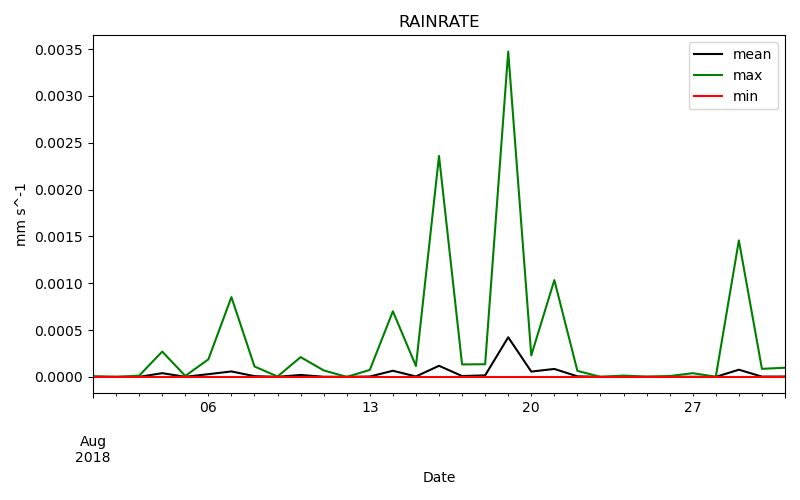

In [16]:
# Plot the mean, min, and max daily RAINRATE for the NLDAS FORCING
f, ax = plt.subplots(1, figsize=(8, 5))

#ax = dat['sum'].plot(label = 'sum', style='b', ax=ax)
_ = dat['mean'].plot(label = 'mean', style='k', ax=ax)
_ = dat['max'].plot(label = 'max', style='g', ax=ax)
_ = dat['min'].plot(label = 'min', style='r', ax=ax)
_ = ax.legend()

ax.set_title(nldas_name)
ax.set_ylabel(nldas_unit)
ax.set_xlabel('Date')

fig.autofmt_xdate()

plt.tight_layout()

## Compare timeseries of GHCN and NLDAS with observed streamflow

#### Plot GHCN and NLDAS precipitation

<IPython.core.display.Javascript object>


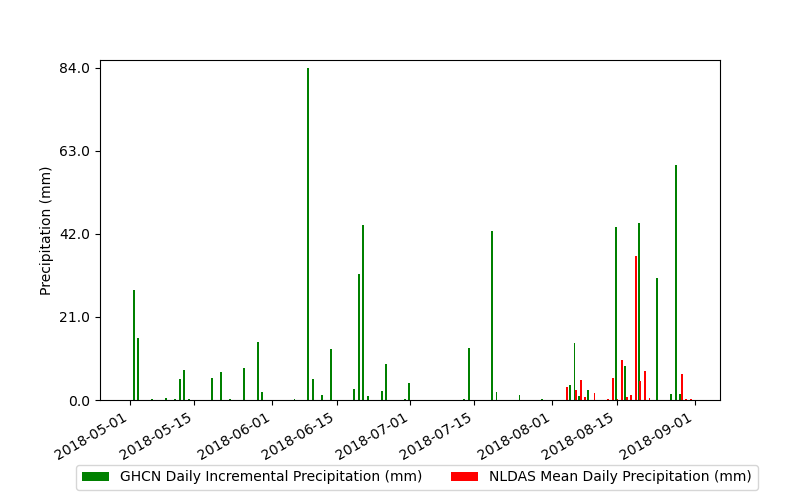

In [17]:
# create plot
fig = plt.figure(figsize=(8,5))
ax = plt.gca()

y, x = list(zip(*nwis_series))


# plot GHCN data (stored in CSV, collected from data.cuahsi.org)

precip = df_ghcn[(df_ghcn.date >= datetime.strptime(start_date, '%Y-%m-%d')) & \
                 (df_ghcn.date <= datetime.strptime(end_date, '%Y-%m-%d')) ]

# 4 hours are subtracted from the date axis to place bars to
# the left of the NLDAS data
ghcn = ax.bar(precip.date - pandas.Timedelta(hours=4), precip.Value,
              color='green', width=0.4,
              label='GHCN Daily Incremental Precipitation (mm)')

# NLDAS RAINRATE is in mm/s, convert to mm/day
daily_total = dat['mean']*60*60*24

# 4 hours are added to the date axis to place bars to
# the right of the GHCN data
nldas = ax.bar(dat.index + pandas.Timedelta(hours=4), daily_total,
              color='red', width=0.4,
              label='NLDAS Mean Daily Precipitation (mm)')

# set the axis limits and formatting
max_pre = max(list(precip.Value.values) + list(daily_total.values))
ax.set_ylim(0, max_pre+2)
y2_ticks = numpy.linspace(0, max_pre, 5)
ax.set_yticks(y2_ticks)
y2_ticklabels = [str(round(i,0)) for i in y2_ticks]
ax.set_yticks(y2_ticks)
ax.set_yticklabels(y2_ticklabels)
ax.set_ylabel('Precipitation (mm)')

# added these three lines
lns = [ghcn, nldas]
labs = [l.get_label() for l in lns]

# put the legend outside the plot
plt.legend(bbox_to_anchor=(-.05, -.17), loc='upper left', ncol=2)


fig.autofmt_xdate()

#### Plot precipitation and streamflow

<IPython.core.display.Javascript object>


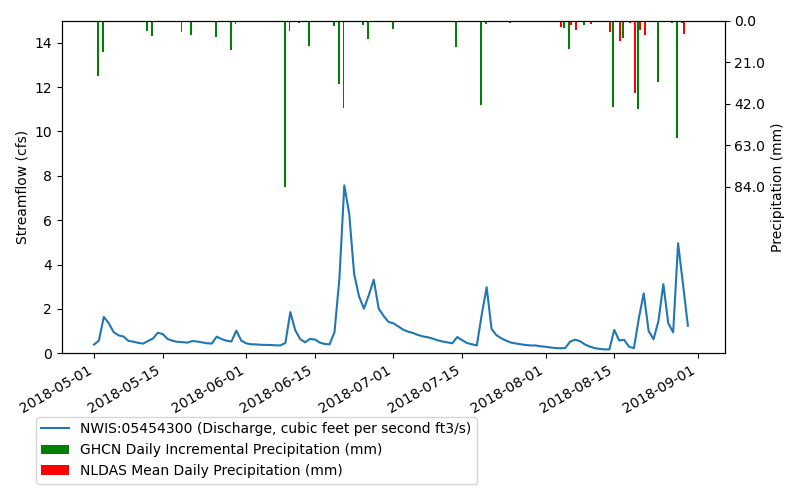

In [18]:
# create plot
fig = plt.figure(figsize=(8,5))
ax = plt.gca()

y, x = list(zip(*nwis_series))

# plot nwis
nwis = ax.plot_date(x, y, '-', label=f'{site_code} ({nwis_metadata["varname"]} {nwis_metadata["varunit"]})')
ax.set_ylabel('Streamflow (cfs)')
ax.set_ylim(0, 15)

# create a separate axis for precipitation
ax2 = ax.twinx()

# plot GHCN data (stored in CSV, collected from data.cuahsi.org)
# 4 hours are subtracted from the date axis to place bars to
# the left of the NLDAS data
ghcn = ax2.bar(precip.date - pandas.Timedelta(hours=4), -precip.Value,
              color='green', width=0.4,
              label='GHCN Daily Incremental Precipitation (mm)')

# NLDAS RAINRATE is in mm/s, convert to mm/day
daily_total = dat['mean']*60*60*24

# 4 hours are added to the date axis to place bars to
# the right of the GHCN data
nldas = ax2.bar(dat.index + pandas.Timedelta(hours=4), -daily_total,
              color='red', width=0.4,
              label='NLDAS Mean Daily Precipitation (mm)')

# set the axis limits and formatting
max_pre = max(list(precip.Value.values) + list(daily_total.values))
ax2.set_ylim(max_pre*-2, 0)
y2_ticks = numpy.linspace(0, max_pre, 5)
ax2.set_yticks(-1 * y2_ticks)
y2_ticklabels = [str(round(i,0)) for i in y2_ticks]
ax2.set_yticks(-1 * y2_ticks)
ax2.set_yticklabels(y2_ticklabels)
ax2.set_ylabel('Precipitation (mm)')

## added these three lines
lns = nwis+[ghcn, nldas]
labs = [l.get_label() for l in lns]

# put the legend outside the plot
plt.legend(lns, labs, bbox_to_anchor=(-.05, -.17), loc='upper left', ncol=1)

fig.autofmt_xdate()
plt.tight_layout()

In [ ]:
# proper daily total calc
# 1. group by hour -> agg.mean()
# 2. group by day -> agg.sum()

In [ ]:
# # Convert Times to datetime objects

# # def convert_bytestr(df):
# #     df.Times = df.Times.map(lambda x: x.decode('utf-8'))
# #     return df



# # def convert_strdt(ds):
# #     return ds.map(lambda x: pandas.to_datetime(x, format='%Y-%m-%d_%H:%M:%S'))



# # def convert_times(df):
# #     df.Times = df.Times.map(lambda x: x.decode('utf-8'))
# #     df.Times = df.Times.map(lambda x: pandas.to_datetime(x, format='%Y-%m-%d_%H:%M:%S'))
# #     return df

# # df = df.map_partitions(convert_times,
# #                        meta=(df))

# def convert_bytestr(df):
#     df.Times = df.Times.map(lambda x: x.decode('utf-8'))
#     return df

# def convert_strdt(df):
#     df.Times = df.Times.map(lambda x: pandas.to_datetime(x, format='%Y-%m-%d_%H:%M:%S'))
#     return df


# def str_to_d64(df):
#     df.Times = df.Times.map(lambda x: pandas.to_datetime(x.decode('utf-8'), format='%Y-%m-%d_%H:%M:%S'))
#     return df

# # df.Times = df.map_partitions(convert_bytestr,
# #                        meta=(df))

# # df = df.map_partitions(convert_strdt,
# #                        meta=('datetime64[ns]'))

# # df = df.map_partitions(str_to_d64, meta=(df))

In [ ]:
# df = df.map_partitions(convert_bytestr, meta=(df))
# df = df.map_partitions(convert_strdt, meta=(df))
# df = df.persist()

In [ ]:
# d = df.compute()

In [ ]:
# d.Times = d.Times.map(lambda x: pandas.to_datetime(x.decode('utf-8'), format='%Y-%m-%d_%H:%M:%S'))

In [ ]:
# apply the delayed operations and return a Dask object 
# for further analysis
# df = df.persist()